In [2]:
import numpy as np
import torch
from sudoku import Sudoku
from matplotlib import pyplot as plt
import deepsudoku as ds
from deepsudoku.utils import data_utils, sudoku_utils

In [3]:
model = ds.model.SimpleNet()

In [4]:
model.load_state_dict(torch.load("documentation/2.pth", map_location=torch.device('cpu'))["model_state_dict"])

<All keys matched successfully>

In [5]:
train_sudokus, val_sudokus, test_sudokus = data_utils.load_data()

In [6]:
loss_fn = torch.nn.CrossEntropyLoss()


In [14]:
def natural_distribution():
    possible_numbers_of_moves_to_make = list(range(0,64))
    with open("data/natural_distribution.np", 'rb') as f:
        probabilities = np.load(f)
    probabilities = probabilities/sum(probabilities)
    return possible_numbers_of_moves_to_make, probabilities

train_sudokus = data_utils.make_moves(train_sudokus, natural_distribution)
val_sudokus = data_utils.make_moves(val_sudokus, natural_distribution)
test_sudokus = data_utils.make_moves(test_sudokus, natural_distribution)


In [15]:
x_test, y_test = data_utils.generate_batch(test_sudokus, augment = False)
x_test = torch.tensor(x_test.reshape(-1,1,9,9).astype('float32'))
y_test = torch.tensor(y_test - 1).type(torch.LongTensor)

In [16]:
dictionary = {}
for i, test_sudoku in enumerate(test_sudokus):
    current_zeros = len(np.argwhere(test_sudoku[0] == 0))
    if current_zeros in dictionary.keys():
        dictionary[current_zeros] += [i]
    else:
        dictionary[current_zeros] = [i]

In [17]:
model.eval()

SimpleNet(
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convs): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (convlast): Conv2d(64, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [18]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [19]:
test_accs_i_1 = test_accs_i

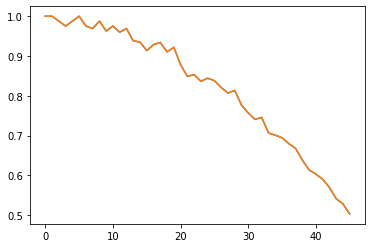

In [20]:
plt.plot(test_accs_i)
plt.plot(test_accs_i_1)

In [21]:
with open("data/natural_distribution.np", 'wb') as f:
    np.save(f, test_losses_i[::-1])

In [22]:
with open("data/natural_distribution.np", 'rb') as f:
    test = np.load(f)

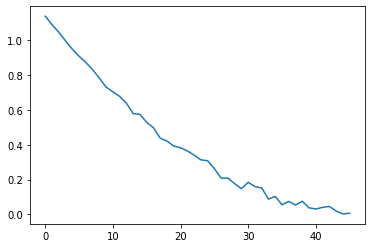

In [23]:
plt.plot(test)

In [24]:
test_losses_i = []
test_accs_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]

    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        test_loss_i = loss_fn(y_pred_test_i, y_test_i)
        indices = torch.max(y_pred_test_i, 1)[1]
        correct = torch.eq(indices, y_test_i).view(-1)
        test_acc_i = torch.sum(correct)/correct.shape[0]

    test_losses_i.append(test_loss_i.item())
    test_accs_i.append(test_acc_i.cpu())

In [32]:
def get_index_of_max_value(sudoku_probabilities):
    max_probabilities_cells, cell_values = torch.max(y_pred_test_i, 1)
    return max_probabilities_cells, cell_values

def get_position_of_max_value(sudoku_probabilities):
    return np.unravel_index(np.argmax(sudoku_probabilities.cpu()), (9,9))


In [33]:
y_pred_test_i.shape

torch.Size([35, 9, 9, 9])

In [34]:
a = y_pred_test_i[0]
print(a.shape)
max_probabilities_cells, cell_values = torch.max(a, 0)
print(max_probabilities_cells.shape)
pos = np.unravel_index(np.argmax(max_probabilities_cells.cpu()), (9,9))
print(max_probabilities_cells)
print(pos)
print(cell_values[pos[0], pos[1]])

torch.Size([9, 9, 9])
torch.Size([9, 9])
tensor([[ 0.6492,  1.6857,  1.2658,  2.3528, 10.2499,  0.6465, 10.8577,  2.3627,
          2.4858],
        [ 0.9733,  2.2803,  0.7962,  2.7666,  1.7266,  1.4560, 14.0651,  2.2525,
          9.8730],
        [ 2.3630, 22.9606,  1.6143, 18.5439,  3.0516,  1.5712,  3.6382,  1.7127,
          1.2961],
        [ 1.3761, 16.3572,  2.6854,  1.4508,  0.3311,  2.1223,  2.1401, 17.1592,
          2.6619],
        [ 2.6908,  2.2098,  1.5923,  2.0984, 16.9115,  1.4662,  3.9417, 13.6680,
          2.6597],
        [ 8.7926,  2.4365,  0.4593,  2.1035,  0.7687,  1.3345,  2.4000,  2.2851,
          1.7128],
        [ 2.7287,  3.8077, 16.8425, 16.1990,  2.9138, 24.2229,  2.1717,  2.7260,
          1.8754],
        [ 7.5323,  0.8036,  3.4665,  3.2923,  1.8411,  3.1032,  9.5369,  1.7830,
          3.2679],
        [ 2.9179,  2.3873,  3.0158, 11.0542,  2.7179,  4.2598,  2.2470,  2.3047,
          1.4756]])
(6, 5)
tensor(3)


In [35]:
most_confident_correct_ratio_i = []

for i in set(dictionary.keys()):

    x_test_i = x_test[dictionary[i]]
    y_test_i = y_test[dictionary[i]]
    
    with torch.no_grad():
        y_pred_test_i = model(x_test_i)
        values, indices = torch.max(y_pred_test_i, 1)

        correct = 0

        for i, (value, index) in enumerate(zip(values,indices)):
            pos = get_position_of_max_value(value)
            correct += index[pos[0], pos[1]] == y_test_i[i, pos[0], pos[1]]

    most_confident_correct_ratio_i.append((correct/len(values)).cpu())

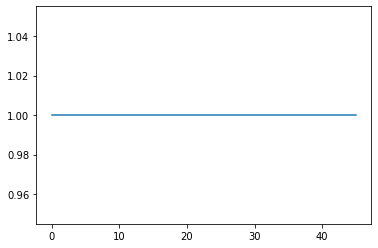

In [36]:
plt.plot(most_confident_correct_ratio_i)

In [38]:
x_test_i.shape

torch.Size([35, 1, 9, 9])

In [40]:
values.shape

torch.Size([11, 9, 9])